### Статистика встречаемости

In [1]:
import sys
sys.path.append('../')

In [31]:
from thesaurus_parsing.thesaurus_parser import ThesaurusParser
from projection_model.models import make_model_vocab
from tqdm import tqdm_notebook as tqdm
import os
import json
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

На текущий момент обработаны только статьи из датасета "Ленты". Качество обученных моделей на этом наборе текстов оказывается низким при применении к тезаурусу Лукашевич.

Возможно, это из-за того, что встречаемости в текстах недостаточно для того, чтобы уловить закономерности в паттернах.

Проверим это в явном виде.

In [3]:
thesaurus = ThesaurusParser("../data/RuThes", need_closure=False, verbose=True)

In [4]:
vocab = make_model_vocab()

In [7]:
DIR_PATH = "/home/loginov-ra/MIPT/HypernymyDetection/data/Lenta/texts_tagged_processed_tree"
file_list = os.listdir(DIR_PATH)
file_list = [os.path.join(DIR_PATH, filename) for filename in file_list]

Пройдёмся по текстам и соберём статистику встречаемости

In [10]:
def is_hyponym_hypernym(hypo_cand, hyper_cand):
    if hypo_cand not in thesaurus.hypernyms_dict:
        return False
    return hyper_cand in thesaurus.hypernyms_dict[hypo_cand]

In [11]:
def get_hypernymy_pairs(multitokens):
    pairs = []
    for i, hypernym_candidate in enumerate(multitokens):
        for j, hyponym_candidate in enumerate(multitokens):
            if i == j:
                continue
            if is_hyponym_hypernym(hyponym_candidate, hypernym_candidate):
                pairs.append((j, i))
    return pairs

In [12]:
thesaurus_vocab = set()

In [14]:
for hyponym, hypernyms in thesaurus.hypernyms_dict.items():
    thesaurus_vocab.add(thesaurus)
    for hypernym in hypernyms:
        thesaurus_vocab.add(hypernym)

In [15]:
len(thesaurus_vocab)

51569

In [68]:
occured_in_text = set()
occured_in_hypernymy = set()

occurences_per_file = []
hypernymy_occurences_per_file = []

In [69]:
for filename in tqdm(file_list):
    with open(filename, encoding='utf-8') as sentences_file:
        occurences = set()
        pair_occurences = set()
        
        sentences = json.load(sentences_file)
        for sent in sentences:
            if 'deeppavlov' not in sent:
                continue
            
            multitokens, main_pos = sent['multi']
            
            if len(multitokens) > 100:
                continue
            
            in_vocab = [token in thesaurus_vocab for token in multitokens]
            
            for word in multitokens:
                if word in thesaurus_vocab:
                    occured_in_text.add(word)
                    occurences.add(word)
            
            for pattern_pair in get_hypernymy_pairs(multitokens):
                hypo_multi, hyper_multi = pattern_pair
                occured_in_hypernymy.add(multitokens[hypo_multi])
                occured_in_hypernymy.add(multitokens[hyper_multi])
                pair_occurences.add(multitokens[hypo_multi] + ' ' + multitokens[hyper_multi])
        
        occurences_per_file.append(len(occurences))
        hypernymy_occurences_per_file.append(len(pair_occurences))

Сначала посмотрим на то, сколько вообще встречается различных гипонимов-гиперонимов

In [70]:
len(occured_in_text)

23757

Это всего около трети от общего количества слов. А сколько всего встречается в парах с гиперонимами?

In [71]:
len(occured_in_hypernymy)

12530

Это ещё в 2 раза меньше

Посмотрим теперь на то, какие тексты содержат много пар с гиперонимией из тезауруса

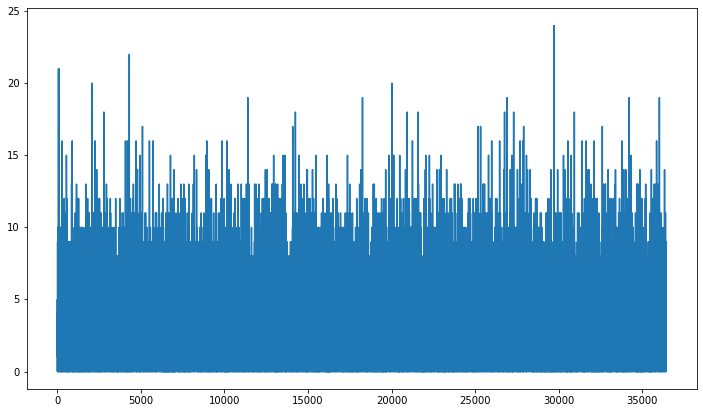

In [72]:
plt.figure(figsize=(12, 7))
plt.plot(np.array(hypernymy_occurences_per_file))
plt.show()

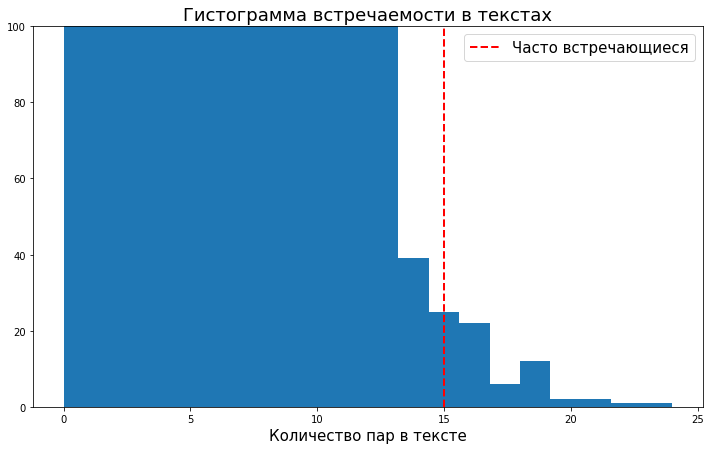

In [74]:
plt.figure(figsize=(12, 7))
plt.title("Гистограмма встречаемости в текстах", fontsize=18)
plt.hist(np.array(hypernymy_occurences_per_file), bins=20)
plt.axvline(15, ls='--', color='red', label="Часто встречающиеся", lw=2)
plt.xlabel('Количество пар в тексте', fontsize=15)
plt.ylim((0, 100))
plt.legend(fontsize=15)
plt.show()

Хочется посмотреть, а что это за файлы такие, и куда копать в поисках хорошего датасета

In [88]:
freq_filenames = []

for file, occurences in zip(file_list, hypernymy_occurences_per_file):
    if occurences >= 20:
        freq_filenames.append(file)
        print(file)

/home/loginov-ra/MIPT/HypernymyDetection/data/Lenta/texts_tagged_processed_tree/20131002wavesreturn.txt_processed.json
/home/loginov-ra/MIPT/HypernymyDetection/data/Lenta/texts_tagged_processed_tree/20160602patrio.txt_processed.json
/home/loginov-ra/MIPT/HypernymyDetection/data/Lenta/texts_tagged_processed_tree/20160209centrobankkolekrory.txt_processed.json
/home/loginov-ra/MIPT/HypernymyDetection/data/Lenta/texts_tagged_processed_tree/20130305petition.txt_processed.json
/home/loginov-ra/MIPT/HypernymyDetection/data/Lenta/texts_tagged_processed_tree/20120201clapper.txt_processed.json
/home/loginov-ra/MIPT/HypernymyDetection/data/Lenta/texts_tagged_processed_tree/20130404freevak.txt_processed.json


In [90]:
for filename in freq_filenames:
    with open(filename, encoding='utf-8') as sentences_file:
        n_occurences = 0
        n_pair_occurences = 0

        sentences = json.load(sentences_file)
        for sent in sentences:
            if 'deeppavlov' not in sent:
                continue

            multitokens, main_pos = sent['multi']

            if len(multitokens) > 100:
                continue

            in_vocab = [token in thesaurus_vocab for token in multitokens]

            for word in multitokens:
                if word in thesaurus_vocab:
                    occured_in_text.add(word)
                    n_occurences += 1

            pairs = set()

            for pattern_pair in get_hypernymy_pairs(multitokens):
                hypo_multi, hyper_multi = pattern_pair
                p = "{} --> {}".format(multitokens[hypo_multi], multitokens[hyper_multi])
                pairs.add(p)

            for p in pairs:
                print(p)
        print()

ссылка --> привести
открытие --> сделать
открытие --> действие
плоскость --> поверхность
позиция --> быть
феномен --> явление
физический величина --> параметр
волна --> волновой
существовать --> быть
волновой --> волна
возникать --> быть
появление --> быть
волна --> волна
возникновение --> быть
наличие --> быть
капля --> частица
прыгать --> перемещаться
показать --> описать
короткий --> маленький
капля --> жидкость
подскакивание --> прыгать
волна --> волна

решение --> выбор
другой --> связь
быть --> связь
участие --> связь
россия --> государство
россия --> страна
быть --> быть
продолжаться --> быть
быть --> находиться
россия --> национальный
остаться --> быть
организовать --> создать
организовать --> реализация
осуществление --> быть
быть --> быть
стратегия --> программа
программа --> план
выработать --> создать
проект --> план
стратегия --> план
проводить --> реализовать
партия --> общественный объединение

ставка --> допускать
просрочить --> нарушение
получить --> связь
жизненный --

География;Финансы;Наука